# ==== INTERACTIVE CLUSTERING : COMPUTATION TIME STUDY ====
> ### Stage 3 : Apply main effects and post-hoc analysis on interactive clustering computation times.

-----

## READ-ME BEFORE RUNNING

### Quick Description

This notebook is **aimed at run main effects and and post-hoc analysis on interactive clustering computation time over experiments**.
- Environments are represented by subdirectories in the `/experiments` folder. A full path to an experiment environment is `/experiments/[TASK]/[DATASET]/[ALGORITHM]/`.
- Experiments have to be run and evaluated in order to analyze convergency speed.

Before running, **run the notebook `2_Estimate_computation_time.ipynb` to run each algorithm you have set**.

Then, **go to the notebook `4_Plot_some_figures.ipynb` to create figures on interactive clustering computation time**.

### Description each steps

First of all, **load experiment synthesis CSV file** that have been computed with the last notebook.
- It contains parameters used for each experiment and convergency metric to compare.
- Several parameters are studied depending on the task:
    - _preprocessing_: `dataset_size`, `algorithm_name`;
    - _vectorization_: `dataset_size`, `algorithm_name`;
    - _sampling_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`, `algorithm_nb_to_select`;
    - _clustering_: `dataset_size`, `algorithm_name`, `previous_nb_constraints`, `previous_nb_clusters`.
- Two random effects are used : `dataset_random_seed`, `algorithm_random_seed`.
- One values is modelized with these factors : `time_total`.

Then, for each task :
1. Compute interaction of factors
2. Sort interaction by correlation
3. Compute Ordinary Least Squares

-----

## 1. IMPORT PYTHON DEPENDENCIES

In [1]:
from typing import Dict, List, Optional, Tuple, Union
import math
import numpy as np
import openpyxl
import pandas as pd
from itertools import combinations_with_replacement, permutations
from matplotlib import pyplot as plt
from matplotlib.figure import Figure
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy import stats as scipystats
import statistics
import statsmodels.formula.api as smf

In [2]:
def compute_combinations_of_interactions_of_factors(
    df: pd.DataFrame,
    factors: List[str],
    range_of_powers: List[int] = [0, 1, 2, 3],
    max_power: int = 3,
) -> Tuple[List[Dict[str, str]], pd.DataFrame]:
    """
        Compute combinations of interactions of factors in dataframe.
        
        Args:
            df (pd.DataFrame): Dataframe of results.
            factors (List[str]): Column of dataframe considered as factors.
            range_of_powers (List[int]): Range of power to compute. Defaults to `[0, 1, 2, 3]`.
            max_power (int): Maximum interaction levl, i.e. maximum sum of powers. Defaults to `3`.
        
        Return:
            Tuple[List[Dict[str, str]], pd.DataFrame]: The factors interactions. and the updated dataframe.
    """

    # The columns computed.
    factors_interactions: List[Dict[str, str]] = []
    
    # Define combinations of powers.
    for power_combination in combinations_with_replacement(range_of_powers, r=len(factors)):
        
        # Define max combination of powers.
        if sum(power_combination)<=0 or (max_power+1)<=sum(power_combination):
            continue

        # Define permutations of combinations of powers.
        for powers in sorted(set(permutations(power_combination)), reverse=True):
            
            # Compute column and value of the combination of factors.
            list_of_Xi: List[Dict] = []
            for i, factor in enumerate(factors):
                if powers[i] != 0:
                    list_of_Xi.append({
                        "xname": "X{0}POW{1}".format(i+1, powers[i]),
                        "fname": "{0}_POW{1}".format(factor, powers[i]),
                        "factor": factor,
                        "power": powers[i],
                    })
            
            column_xname: str = "_".join([x["xname"] for x in list_of_Xi])
            column_fname: str = "__x__".join([x["fname"] for x in list_of_Xi])
            factors_interactions.append({
                "xname": column_xname,
                "fname": column_fname,
            })
            df[column_xname] = df.apply(
                lambda row: math.prod(
                    np.power(row[x["factor"]], x["power"])
                    for x in list_of_Xi
                ),
                axis=1,
            )
    return factors_interactions, df

In [3]:
def compute_correlation_of_factors(
    df: pd.DataFrame,
    factors_interactions: List[Dict[str, str]],
    algorithm_name: str,
) -> pd.DataFrame:
    """
        Compute Pearson (standard) correlation coefficient between factors and computed time.

        Args:
            df (pd.DataFrame): Dataframe of results.
            factors_interactions (List[Dict[str, str]]): List of columns in dataframe that correspond to computed interaction between factors.
            algorithm_name (str): The algithm name to filter dataframe.
        
        Return:
            pd.DataFrame: The correlation of combination of factors to algorithm computation time.
    """
    # Get columns of factors interactions
    columns_of_factors_interactions: List[str] = [col["xname"] for col in factors_interactions]
    
    # Filter data on `algorithm_name`.
    df_subset = (
        df
        if algorithm_name is None
        else df[df["algorithm_name"]==algorithm_name]
    )
    
    # Compute correlation.
    df_correlation = df_subset.loc[
        # Exclude columns that are not factors.
        :, df.columns.isin(["time_total"] + columns_of_factors_interactions)
    ].corr(
        # Get correlation of factors.
    )["time_total"].apply(
        # Get the absolute value of correlation.
        lambda x: abs(x)
    ).sort_values(
        # Sort by correlation.
        ascending=False
    ).to_frame(
        # Format in pd.Series
        name="R"
    ).drop(
        # Drop time column.
        ["time_total"]
    )
    
    # Compute R^2.
    df_correlation["R^2"] = np.power(df_correlation["R"], 2)
    
    # Compute base factor to sort interactions.
    df_correlation["base_factor"] = df_correlation.apply(
        lambda row: row.name.replace("POW0", "").replace("POW1", "").replace("POW2", "").replace("POW3", "").replace("POW4", ""),
        axis=1,
    )
    
    # Filter correlation results.
    df_correlation = df_correlation.drop_duplicates(
        # On several relevant correlations on a same factor/combinaison of factors : get the first one.
        subset=["base_factor"],
        keep="first",
    )

    # Show.
    return df_correlation

In [4]:
def compute_information_score_evolution(
    df: pd.DataFrame,
    df_correlation: pd.DataFrame,
    algorithm_name: str,
    information_criterion_to_plot: str = "llf",
) -> pd.DataFrame:
    """
        Compute ordinary least squares model based on top correlation factors.

        Args:
            df (pd.DataFrame): Dataframe of results.
            df_correlation (pd.DataFrame): The correlation of combination of factors to algorithm computation time.
            algorithm_name (str): The algithm name to filter dataframe.
            information_criterion_to_plot (str): Information criterion to plot. Defaults to `llf`.
        
        Return:
            Dict: Evolution of information score of ordinary least squares model based on top correlation factors.
    """
    
    information_score_evolution = []
    factors = []
    
    # For each factor...
    for i, factor in enumerate(list(df_correlation.index)):
        # Compute modelization with previous factors and this new one.
        factors.append(factor)
        model = smf.ols(
            formula="time_total ~ " + " + ".join(factors),
            data=(
                df
                if algorithm_name is None
                else df[df["algorithm_name"]==algorithm_name]
            ),
        )
        result = model.fit()
        
        # Store results.
        information_score_evolution.append({
            "factors": factors.copy(),
            "scores": {"aic": result.aic, "bic": result.bic, "rsquared": result.rsquared, "llf": result.llf}
        })
        
    # Create a new figure.
    fig_plot: Figure = plt.figure(figsize=(15, 7.5), dpi=100)
    axis_plot = fig_plot.gca()

    # Plot information criteria.
    axis_plot.plot(
        [str(i+1) for i in range(len(information_score_evolution))],  # x
        [result["scores"][information_criterion_to_plot] for result in information_score_evolution],  # y
        label=information_criterion_to_plot,
        marker="x",
        markerfacecolor="red",
        markersize=3,
        color="red",
        linewidth=1,
        linestyle="-",
    )

    # Set axis name.
    axis_plot.set_xlabel("number of factors (reverse order by correlation) (#)", fontsize=18,)
    axis_plot.set_ylabel("information criterion score (?)", fontsize=18,)

    # Plot the legend.
    axis_plot.legend(fontsize=15,)

    # Plot the grid.
    axis_plot.grid(True)
    
    return information_score_evolution

-----

## 2.1. ANALYSIS FOR PREPROCESSING

> - algorithms: `simple_prep`, `lemma_prep`, `filter_prep`
> - factors: `dataset_size`

In [ ]:
df_preprocessing = pd.read_csv("../results/experiments_synthesis_for_preprocessing.csv", sep=";")
df_preprocessing["time_total"] = df_preprocessing["time_total"].str.replace(",", ".").astype(float)
df_preprocessing.head()

In [ ]:
# Compute interaction of factors for preprocessing.
factors_interactions_for_preprocessing, df_preprocessing = compute_combinations_of_interactions_of_factors(
    df=df_preprocessing,
    factors=["dataset_size"],
    range_of_powers=[0, 1, 2, 3],
    max_power=3
)
factors_interactions_for_preprocessing

### 2.1.0. Dertermine if preprocessing computation time is `algorithm_name` dependant.

In [ ]:
# Fit the model to the data and print results.
model_prep_ALGONAME = smf.ols(
    formula="time_total ~ C(algorithm_name)",
    data=df_preprocessing,
)
results_prep_ALGONAME = model_prep_ALGONAME.fit()
print(results_prep_ALGONAME.summary())

### 2.1.1. Modelize all preprocessing `algorithm_name`.

In [ ]:
# Compute correlation of factors for preprocessing.
df_correlation_preprocessing: pd.DataFrame = compute_correlation_of_factors(
    df=df_preprocessing,
    factors_interactions=factors_interactions_for_preprocessing,
    algorithm_name=None,
)
df_correlation_preprocessing

In [ ]:
information_score_evolution_for_preprocessing = compute_information_score_evolution(
    df=df_preprocessing,
    df_correlation=df_correlation_preprocessing,
    algorithm_name=None,
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_preprocessing)

> `preprocessing ~ dataset_size`

In [ ]:
# Fit the model to the data and print results.
best_model_prep = smf.ols(
    formula="time_total ~ X1POW1",  # X1POW1 = dataset_size
    data=df_preprocessing,
)
best_results_prep= best_model_prep.fit()
print(best_results_prep.summary())

> `preprocessing = 0.0063(+/-2.44e-05)*dataset_size  +  0.8927(+/-0.081)`

In [ ]:
# Define the interpolation function.
def interpolation_prep(dataset_size) -> float:
    res: float = 0
    if best_results_prep.pvalues["Intercept"] < 0.05:
        res += best_results_prep.params["Intercept"]
    if best_results_prep.pvalues["X1POW1"] < 0.05:
        res += best_results_prep.params["X1POW1"] * dataset_size
    return res

### 3.1.2. Print all preprocessing computation time model.

In [ ]:
# Create a new figure.
fig_plot_preprocessing: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_preprocessing = fig_plot_preprocessing.gca()

# Plot computation time for preprocessing.
axis_plot_preprocessing.plot(
    df_preprocessing["dataset_size"],  # x
    df_preprocessing["time_total"],  # y
    label="prep: observations",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_preprocessing.plot(
    range(0, 5500, 100),  # x
    interpolation_prep(range(0, 5500, 100)),  # y
    label="prep: interpolation",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_preprocessing.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_preprocessing.set_ylabel("temps de calcul (s)", fontsize=18,)

# Plot the legend.
axis_plot_preprocessing.legend(fontsize=15,)

# Plot the grid.
axis_plot_preprocessing.grid(True)

----------

## 2.2. ANALYSIS FOR VECTORIZATION

> - algorithms: `tfidf`, `spacy`
> - factors: `dataset_size`

In [ ]:
df_vectorization = pd.read_csv("../results/experiments_synthesis_for_vectorization.csv", sep=";")
df_vectorization["time_total"] = df_vectorization["time_total"].str.replace(",", ".").astype(float)
df_vectorization.head()

In [ ]:
# Compute interaction of factors for preprocessing.
factors_interactions_for_vectorization, df_vectorization = compute_combinations_of_interactions_of_factors(
    df=df_vectorization,
    factors=["dataset_size"],
    range_of_powers=[0, 1, 2, 3],
    max_power=3
)
factors_interactions_for_vectorization

### 2.2.0. Dertermine if vectorization computation time is `algorithm_name` dependant.

In [ ]:
# Fit the model to the data and print results.
model_vect_ALGONAME = smf.ols(
    formula="time_total ~ C(algorithm_name)",
    data=df_vectorization,
)
results_vect_ALGONAME = model_vect_ALGONAME.fit()
print(results_vect_ALGONAME.summary())

### 2.2.1 Modelize `tfidf` vectorization `algorithm_name`.

In [ ]:
# Compute correlation of factors for vectorization.
df_correlation_vectorization_tfidf: pd.DataFrame = compute_correlation_of_factors(
    df=df_vectorization,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="tfidf",
)
df_correlation_vectorization_tfidf

In [ ]:
information_score_evolution_for_vectorization_tfidf = compute_information_score_evolution(
    df=df_vectorization,
    df_correlation=df_correlation_vectorization_tfidf,
    algorithm_name="tfidf",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_vectorization_tfidf)

> `vectorization.tfidf ~ dataset_size`

In [ ]:
# Fit the model to the data and print results.
best_model_vect_tfidf = smf.ols(
    formula="time_total ~ X1POW1",  # X1POW1 = dataset_size
    data=df_vectorization[df_vectorization["algorithm_name"]=="tfidf"],
)
best_results_vect_tfidf = best_model_vect_tfidf.fit()
print(best_results_vect_tfidf.summary())

> `vectorization.tfidf = 9.542e-05(+/-1.89e-06)*dataset_size  +  -0.0140(+/-0.006)`

In [ ]:
# Define the interpolation function.
def interpolation_vect_tfidf(dataset_size) -> float:
    res: float = 0
    if best_results_vect_tfidf.pvalues["Intercept"] < 0.05:
        res += best_results_vect_tfidf.params["Intercept"]
    if best_results_vect_tfidf.pvalues["X1POW1"] < 0.05:
        res += best_results_vect_tfidf.params["X1POW1"] * dataset_size
    return res

### 2.2.2. Modelize `frcorenewsmd` vectorization `algorithm_name`.

In [ ]:
# Compute correlation of factors for vectorization.
df_correlation_vectorization_spacy: pd.DataFrame = compute_correlation_of_factors(
    df=df_vectorization,
    factors_interactions=factors_interactions_for_vectorization,
    algorithm_name="spacy",
)
df_correlation_vectorization_tfidf

In [ ]:
information_score_evolution_for_vectorization_spacy = compute_information_score_evolution(
    df=df_vectorization,
    df_correlation=df_correlation_vectorization_spacy,
    algorithm_name="spacy",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_vectorization_spacy)

> `vectorization.spacy ~ dataset_size`

In [ ]:
# Fit the model to the data and print results.
best_model_vect_frcorenewsmd = smf.ols(
    formula="time_total ~ X1POW1",  # X1POW1 = dataset_size
    data=df_vectorization[df_vectorization["algorithm_name"]=="spacy"],
)
best_results_vect_frcorenewsmd = best_model_vect_frcorenewsmd.fit()
print(best_results_vect_frcorenewsmd.summary())

> `vectorization.spacy =  0.0041(+/-6.88e-05)*dataset_size  +  1.8862(+/-0.228)`

In [ ]:
# Define the interpolation function.
def interpolation_vect_frcorenewsmd(dataset_size) -> float:
    res: float = 0
    if best_results_vect_frcorenewsmd.pvalues["Intercept"] < 0.05:
        res += best_results_vect_frcorenewsmd.params["Intercept"]
    if best_results_vect_frcorenewsmd.pvalues["X1POW1"] < 0.05:
        res += best_results_vect_frcorenewsmd.params["X1POW1"] * dataset_size
    return res

### 2.2.3. Print all vectorization computation time model.

In [ ]:
# Create a new figure.
fig_plot_vectorization: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_vectorization = fig_plot_vectorization.gca()

# Plot computation time for tfidf.
axis_plot_vectorization.plot(
    df_vectorization[df_vectorization["algorithm_name"]=="tfidf"]["dataset_size"],  # x
    df_vectorization[df_vectorization["algorithm_name"]=="tfidf"]["time_total"],  # y
    label="vect.tfidf: observations",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_vectorization.plot(
    range(0, 5500, 100),  # x
    interpolation_vect_tfidf(range(0, 5500, 100)),  # y
    label="vect.tfidf: interpolation",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for frcorenewsmd.
axis_plot_vectorization.plot(
    df_vectorization[df_vectorization["algorithm_name"]=="spacy"]["dataset_size"],  # x
    df_vectorization[df_vectorization["algorithm_name"]=="spacy"]["time_total"],  # y
    label="vect.frcorenewsmd: observations",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_vectorization.plot(
    range(0, 5500, 100),  # x
    interpolation_vect_frcorenewsmd(range(0, 5500, 100)),  # y
    label="vect.frcorenewsmd: interpolation",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_vectorization.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_vectorization.set_ylabel("temps de calcul (s)", fontsize=18,)

# Plot the legend.
axis_plot_vectorization.legend(fontsize=15,)

# Plot the grid.
axis_plot_vectorization.grid(True)

----------

## 2.3. ANALYSIS FOR CLUSTERING

> - algorithms: `kmeans_COP`, `hier_single`, `hier_complete`, `hier_average`, `hier_ward`, `spectral_SPEC`
> - factors: `dataset_size`, `previous_nb_constraints`, `algorithm_nb_clusters`

In [ ]:
df_clustering = pd.read_csv("../results/experiments_synthesis_for_clustering.csv", sep=";")
df_clustering["time_total"] = df_clustering["time_total"].str.replace(",", ".").astype(float)
df_clustering.head()

In [ ]:
# Compute interaction of factors for clustering.
factors_interactions_for_clustering, df_clustering = compute_combinations_of_interactions_of_factors(
    df=df_clustering,
    factors=["dataset_size", "previous_nb_constraints", "algorithm_nb_clusters"],
    range_of_powers=[0, 1, 2, 3],
    max_power=3
)
factors_interactions_for_clustering

### 2.3.0. Dertermine if clustering computation time is `algorithm_name` dependant.

In [ ]:
# Fit the model to the data and print results.
model_clust_ALGONAME = smf.ols(
    formula="time_total ~ C(algorithm_name)",
    data=df_clustering,
)
results_clust_ALGONAME = model_clust_ALGONAME.fit()
print(results_clust_ALGONAME.summary())

### 2.3.1. Modelize `kmeans_COP` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_kmeans_COP: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="kmeans_COP",
)
df_correlation_clustering_kmeans_COP

In [ ]:
information_score_evolution_for_clustering_kmeans_COP = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_kmeans_COP,
    algorithm_name="kmeans_COP",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_kmeans_COP)

> `clustering.kmeans_COP ~ dataset_size + dataset_size**2 * algorithm_nb_clusters`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_kmeans_COP = smf.ols(
    formula="time_total ~ X1POW1 + X1POW2_X3POW1",  # dataset_size + (dataset_size**2 * algorithm_nb_clusters)
    data=df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"],
)
best_results_clust_kmeans_COP = best_model_clust_kmeans_COP.fit()
print(best_results_clust_kmeans_COP.summary())

> `clustering.kmeans_COP = -281.1181(+/-4.076)  +  0.2461(+/-0.002)*dataset_size  +  -2.155e-07(+/-7.83e-09) * dataset_size**2 * algorithm_nb_clusters`

In [ ]:
# Define the interpolation function.
def interpolation_clust_kmeans_COP(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_kmeans_COP.pvalues["Intercept"] < 0.05:
        res += best_results_clust_kmeans_COP.params["Intercept"]
    if best_results_clust_kmeans_COP.pvalues["X1POW1"] < 0.05:
        res += best_results_clust_kmeans_COP.params["X1POW1"] * dataset_size
    if best_results_clust_kmeans_COP.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_clust_kmeans_COP.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * algorithm_nb_clusters
    return res

### 2.3.2. Modelize `hier_single` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_single: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_single",
)
df_correlation_clustering_hier_single

In [ ]:
information_score_evolution_for_clustering_hier_single = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_single,
    algorithm_name="hier_single",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_hier_single)

> `clustering.hier_single ~ dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_hier_single = smf.ols(
    # formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X2POW1 + X1POW1_X2POW1_X3POW1 + X2POW1",
    formula="time_total ~ X1POW2 + X1POW1_X2POW1 + X2POW1",  # dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints
    data=df_clustering[df_clustering["algorithm_name"]=="hier_single"],
)
best_results_clust_hier_single = best_model_clust_hier_single.fit()
print(best_results_clust_hier_single.summary())

> `clustering.hier_single = -1179.7119(+/-15.519) +  0.0009(+/-3.07e-06) * dataset_size**2 + -0.0004(+/-4.28e-06) * dataset_size * previous_nb_constraints + 0.4444(+/-0.008) * previous_nb_constraints`

In [ ]:
# Define the interpolation function.
def interpolation_clust_hier_single(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_hier_single.pvalues["Intercept"] < 0.05:
        res += best_results_clust_hier_single.params["Intercept"]
    if best_results_clust_hier_single.pvalues["X1POW2"] < 0.05:
        res += best_results_clust_hier_single.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_clust_hier_single.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_clust_hier_single.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    if best_results_clust_hier_single.pvalues["X2POW1"] < 0.05:
        res += best_results_clust_hier_single.params["X2POW1"] * previous_nb_constraints
    return res

### 2.3.3. Modelize `hier_complete` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_complete: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_complete",
)
df_correlation_clustering_hier_complete

In [ ]:
information_score_evolution_for_clustering_hier_complete = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_complete,
    algorithm_name="hier_complete",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_hier_complete)

> `clustering.hier_complete ~ dataset_size**2 + dataset_size**2 * algorithm_nb_clusters + dataset_size * previous_nb_constraints + previous_nb_constraints`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_hier_complete = smf.ols(
    # formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X2POW1 + X1POW1_X2POW1_X3POW1 + X2POW1",
    formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X2POW1 + X2POW1",  # dataset_size**2 + dataset_size**2 * algorithm_nb_clusters + dataset_size * previous_nb_constraints + previous_nb_constraints
    data=df_clustering[df_clustering["algorithm_name"]=="hier_complete"],
)
best_results_clust_hier_complete = best_model_clust_hier_complete.fit()
print(best_results_clust_hier_complete.summary())

> `clustering.hier_complete = -1201.7230(+/-19.668) + 0.0008(+/-4.74e-06) * dataset_size**2 + 4.166e-07(+/-9.8e-08) * dataset_size**2 * algorithm_nb_clusters + -0.0003(+/-5.43e-06) * dataset_size * previous_nb_constraints + 0.3952(+/-0.011) * previous_nb_constraints`

In [ ]:
# Define the interpolation function.
def interpolation_clust_hier_complete(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_hier_complete.pvalues["Intercept"] < 0.05:
        res += best_results_clust_hier_complete.params["Intercept"]
    if best_results_clust_hier_complete.pvalues["X1POW2"] < 0.05:
        res += best_results_clust_hier_complete.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_clust_hier_complete.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_clust_hier_complete.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * algorithm_nb_clusters
    if best_results_clust_hier_complete.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_clust_hier_complete.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    if best_results_clust_hier_complete.pvalues["X2POW1"] < 0.05:
        res += best_results_clust_hier_complete.params["X2POW1"] * previous_nb_constraints
    return res

### 2.3.4. Modelize `hier_average` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_average: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_average",
)
df_correlation_clustering_hier_average

In [ ]:
information_score_evolution_for_clustering_hier_average = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_average,
    algorithm_name="hier_average",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_hier_average)

> `clustering.hier_average ~ dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_hier_average = smf.ols(
    # formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X2POW1 + X1POW1_X2POW1_X3POW1 + X2POW1",
    formula="time_total ~ X1POW2 + X1POW1_X2POW1 + X2POW1",  # dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints
    data=df_clustering[df_clustering["algorithm_name"]=="hier_average"],
)
best_results_clust_hier_average = best_model_clust_hier_average.fit()
print(best_results_clust_hier_average.summary())

> `clustering.hier_average = -1361.6771(+/-37.365) + 0.0013(+/-7.4e-06) * dataset_size**2 + -0.0006(+/-1.03e-05) * dataset_size * previous_nb_constraints + 0.5950(+/-0.020) * previous_nb_constraints`

In [ ]:
# Define the interpolation function.
def interpolation_clust_hier_average(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_hier_average.pvalues["Intercept"] < 0.05:
        res += best_results_clust_hier_average.params["Intercept"]
    if best_results_clust_hier_average.pvalues["X1POW2"] < 0.05:
        res += best_results_clust_hier_average.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_clust_hier_average.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_clust_hier_average.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    if best_results_clust_hier_average.pvalues["X2POW1"] < 0.05:
        res += best_results_clust_hier_average.params["X2POW1"] * previous_nb_constraints
    return res

### 2.3.5. Modelize `hier_ward` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_hier_ward: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="hier_ward",
)
df_correlation_clustering_hier_ward

In [ ]:
information_score_evolution_for_clustering_hier_ward = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_hier_ward,
    algorithm_name="hier_ward",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_hier_ward)

> `clustering.hier_ward ~ dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_hier_ward = smf.ols(
    formula="time_total ~ X1POW2 + X1POW1_X2POW1 + X2POW1",  # dataset_size**2 + dataset_size * previous_nb_constraints + previous_nb_constraints
    data=df_clustering[df_clustering["algorithm_name"]=="hier_ward"],
)
best_results_clust_hier_ward = best_model_clust_hier_ward.fit()
print(best_results_clust_hier_ward.summary())

> `clustering.hier_ward = -1286.2029(+/-16.294) + 0.0009(+/-3.23e-06) * dataset_size**2 + -0.0004(+/-4.5e-06) * dataset_size * previous_nb_constraints + 0.4515(+/-0.009) * previous_nb_constraints`

In [ ]:
# Define the interpolation function.
def interpolation_clust_hier_ward(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_hier_ward.pvalues["Intercept"] < 0.05:
        res += best_results_clust_hier_ward.params["Intercept"]
    if best_results_clust_hier_ward.pvalues["X1POW2"] < 0.05:
        res += best_results_clust_hier_ward.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_clust_hier_ward.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_clust_hier_ward.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    if best_results_clust_hier_ward.pvalues["X2POW1"] < 0.05:
        res += best_results_clust_hier_ward.params["X2POW1"] * previous_nb_constraints
    return res

### 2.3.6. Modelize `spectral_SPEC` clustering `algorithm_name`.

In [ ]:
# Compute correlation of factors for clustering.
df_correlation_clustering_spectral_SPEC: pd.DataFrame = compute_correlation_of_factors(
    df=df_clustering,
    factors_interactions=factors_interactions_for_clustering,
    algorithm_name="spectral_SPEC",
)
df_correlation_clustering_spectral_SPEC

In [ ]:
information_score_evolution_for_clustering_spectral_SPEC = compute_information_score_evolution(
    df=df_clustering,
    df_correlation=df_correlation_clustering_spectral_SPEC,
    algorithm_name="spectral_SPEC",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_clustering_spectral_SPEC)

> `clustering.hier_ward ~ dataset_size**2 + dataset_size**2 * algorithm_nb_clusters + dataset_size * previous_nb_constraints * algorithm_nb_clusters`

In [ ]:
# Fit the model to the data and print results.
best_model_clust_spectral_SPEC = smf.ols(
    formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X2POW1_X3POW1",  # dataset_size**2 + dataset_size**2 * algorithm_nb_clusters + dataset_size * previous_nb_constraints * algorithm_nb_clusters
    data=df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"],
)
best_results_clust_spectral_SPEC = best_model_clust_spectral_SPEC.fit()
print(best_results_clust_spectral_SPEC.summary())

> `clustering.spectral_SPEC = 14.6156(+/-1.058) + 5.401e-06(+/-1.13e-07) * dataset_size**2 + -9.521e-08(+/-3.78e-09) * dataset_size**2 * algorithm_nb_clusters + -4.207e-08(+/-3.75e-09) * dataset_size * previous_nb_constraints * algorithm_nb_clusters`

In [ ]:
# Define the interpolation function.
def interpolation_clust_spectral_SPEC(dataset_size, previous_nb_constraints, algorithm_nb_clusters) -> float:
    res: float = 0
    if best_results_clust_spectral_SPEC.pvalues["Intercept"] < 0.05:
        res += best_results_clust_spectral_SPEC.params["Intercept"]
    if best_results_clust_spectral_SPEC.pvalues["X1POW2"] < 0.05:
        res += best_results_clust_spectral_SPEC.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_clust_spectral_SPEC.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_clust_spectral_SPEC.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * algorithm_nb_clusters
    if best_results_clust_spectral_SPEC.pvalues["X1POW1_X2POW1_X3POW1"] < 0.05:
        res += best_results_clust_spectral_SPEC.params["X1POW1_X2POW1_X3POW1"] * dataset_size * previous_nb_constraints * algorithm_nb_clusters
    return res

### 2.3.7. Print all clustering computation time model.

In [ ]:
# Create a new figure.
fig_plot_clustering: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_clustering = fig_plot_clustering.gca()

# Plot computation time for kmeans_COP.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="kmeans_COP"]["time_total"],  # y
    label="clust.kmeans.cop: observations",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_kmeans_COP(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.kmeans.cop: interpolation",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for hier_single.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_single"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_single"]["time_total"],  # y
    label="clust.hier.sing: observations",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_single(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.hier.sing: interpolation",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for hier_complete.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_complete"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_complete"]["time_total"],  # y
    label="clust.hier.comp: observations",
    marker="x",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_complete(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.hier.comp: interpolation",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for hier_average.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_average"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_average"]["time_total"],  # y
    label="clust.hier.avg: observations",
    marker="x",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_average(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.hier.avg: interpolation",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for hier_ward.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="hier_ward"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="hier_ward"]["time_total"],  # y
    label="clust.hier.ward: observations",
    marker="x",
    markerfacecolor="violet",
    markersize=3,
    color="violet",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_hier_ward(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.hier.ward: interpolation",
    marker="",
    markerfacecolor="violet",
    markersize=3,
    color="violet",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for spectral_SPEC.
axis_plot_clustering.plot(
    df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"]["dataset_size"],  # x
    df_clustering[df_clustering["algorithm_name"]=="spectral_SPEC"]["time_total"],  # y
    label="clust.spec: observations",
    marker="x",
    markerfacecolor="cyan",
    markersize=3,
    color="cyan",
    linewidth=0,
    linestyle="",
)
axis_plot_clustering.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_clust_spectral_SPEC(x, y, z)
            for y in range(0, 5500, 500)
            for z in range(0, 55, 10)
        ])
        for x in range(0, 5500, 100)
    ],
    label="clust.spec: interpolation",
    marker="",
    markerfacecolor="cyan",
    markersize=3,
    color="cyan",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_clustering.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_clustering.set_ylabel("temps de calcul (s)", fontsize=18,)
axis_plot_clustering.set_ylim(ymax=30000)

# Plot the legend.
axis_plot_clustering.legend(fontsize=15,)

# Plot the grid.
axis_plot_clustering.grid(True)

----------

## 2.4. ANALYSIS FOR SAMPLING

> - algorithms: `random`, `in_same`, `farthest`, `closest`
> - factors: `dataset_size`, `previous_nb_constraints`, `previous_nb_clusters`, `algorithm_nb_to_select`

In [5]:
df_sampling = pd.read_csv("../results/experiments_synthesis_for_sampling.csv", sep=";")
df_sampling["time_total"] = df_sampling["time_total"].str.replace(",", ".").astype(float)
df_sampling.head()

,Unnamed: 0,dataset_name,dataset_size,dataset_random_seed,previous_nb_constraints,previous_nb_clusters,algorithm_name,algorithm_random_seed,algorithm_nb_to_select,time_start,time_stop,time_total
0,../experiments/sampling/bank_cards_v2-size_100...,bank_cards_v2,1000,1,0,10,closest,1,100,1668608444,1668608445,1.140008
1,../experiments/sampling/bank_cards_v2-size_100...,bank_cards_v2,1000,1,0,20,closest,1,100,1668608471,1668608472,1.220560
2,../experiments/sampling/bank_cards_v2-size_100...,bank_cards_v2,1000,1,0,30,closest,1,100,1668608496,1668608497,1.208447
3,../experiments/sampling/bank_cards_v2-size_100...,bank_cards_v2,1000,1,0,40,closest,1,100,1668608525,1668608526,1.234345
4,../experiments/sampling/bank_cards_v2-size_100...,bank_cards_v2,1000,1,0,50,closest,1,100,1668608548,1668608549,1.198265


In [6]:
# Compute interaction of factors for sampling.
factors_interactions_for_sampling, df_sampling = compute_combinations_of_interactions_of_factors(
    df=df_sampling,
    factors=["dataset_size", "previous_nb_constraints", "previous_nb_clusters", "algorithm_nb_to_select"],
    range_of_powers=[0, 1, 2, 3],
    max_power=3,
)
factors_interactions_for_sampling

C:\Users\SCHILDEW\AppData\Local\Temp\ipykernel_14292\1822018308.py:51: RuntimeWarning: overflow encountered in long_scalars
  lambda row: math.prod(


[{'xname': 'X1POW1', 'fname': 'dataset_size_POW1'},
 {'xname': 'X2POW1', 'fname': 'previous_nb_constraints_POW1'},
 {'xname': 'X3POW1', 'fname': 'previous_nb_clusters_POW1'},
 {'xname': 'X4POW1', 'fname': 'algorithm_nb_to_select_POW1'},
 {'xname': 'X1POW2', 'fname': 'dataset_size_POW2'},
 {'xname': 'X2POW2', 'fname': 'previous_nb_constraints_POW2'},
 {'xname': 'X3POW2', 'fname': 'previous_nb_clusters_POW2'},
 {'xname': 'X4POW2', 'fname': 'algorithm_nb_to_select_POW2'},
 {'xname': 'X1POW3', 'fname': 'dataset_size_POW3'},
 {'xname': 'X2POW3', 'fname': 'previous_nb_constraints_POW3'},
 {'xname': 'X3POW3', 'fname': 'previous_nb_clusters_POW3'},
 {'xname': 'X4POW3', 'fname': 'algorithm_nb_to_select_POW3'},
 {'xname': 'X1POW1_X2POW1',
  'fname': 'dataset_size_POW1__x__previous_nb_constraints_POW1'},
 {'xname': 'X1POW1_X3POW1',
  'fname': 'dataset_size_POW1__x__previous_nb_clusters_POW1'},
 {'xname': 'X1POW1_X4POW1',
  'fname': 'dataset_size_POW1__x__algorithm_nb_to_select_POW1'},
 {'xname': 

### 2.4.0. Dertermine if sampling computation time is `algorithm_name` dependant.

In [7]:
# Fit the model to the data and print results.
model_samp_ALGONAME = smf.ols(
    formula="time_total ~ C(algorithm_name)",
    data=df_sampling,
)
results_samp_ALGONAME = model_samp_ALGONAME.fit()
print(results_samp_ALGONAME.summary())

                            OLS Regression Results                            
Dep. Variable:             time_total   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                 1.861e+04
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:34:36   Log-Likelihood:            -4.7706e+05
No. Observations:              137500   AIC:                         9.541e+05
Df Residuals:                  137496   BIC:                         9.542e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

### 2.4.1. Modelize `random` sampling `algorithm_name`.

In [8]:
# Compute correlation of factors for sampling.
df_correlation_sampling_random: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="random",
)
df_correlation_sampling_random

,R,R^2,base_factor
X1POW2,0.993310,0.986665,X1
X1POW2_X3POW1,0.791089,0.625822,X1_X3
X1POW1_X4POW1,0.646210,0.417588,X1_X4
X1POW1_X2POW1,0.587110,0.344699,X1_X2
X1POW1_X3POW1_X4POW1,0.500793,0.250794,X1_X3_X4
X1POW1_X2POW1_X3POW1,0.474898,0.225528,X1_X2_X3
X1POW1_X2POW1_X4POW1,0.062744,0.003937,X1_X2_X4
X2POW1,0.044070,0.001942,X2
X2POW1_X3POW1,0.033916,0.001150,X2_X3
X2POW1_X4POW1,0.031211,0.000974,X2_X4


[{'factors': ['X1POW2'], 'scores': {'aic': 86536.74527990085, 'bic': 86553.63544957078, 'rsquared': 0.9866649243735721, 'llf': -43266.37263995042}}, {'factors': ['X1POW2', 'X1POW2_X3POW1'], 'scores': {'aic': 86527.28851019475, 'bic': 86552.62376469966, 'rsquared': 0.9866693680516507, 'llf': -43260.64425509737}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1'], 'scores': {'aic': 86270.25211712916, 'bic': 86304.03245646904, 'rsquared': 0.9867694448740079, 'llf': -43131.12605856458}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1'], 'scores': {'aic': 78796.279034344, 'bic': 78838.50445851884, 'rsquared': 0.9893554706559243, 'llf': -39393.139517172}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1POW1_X3POW1_X4POW1'], 'scores': {'aic': 78797.9355666825, 'bic': 78848.60607569231, 'rsquared': 0.9893555770132577, 'llf': -39392.96778334125}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1POW1_X3POW

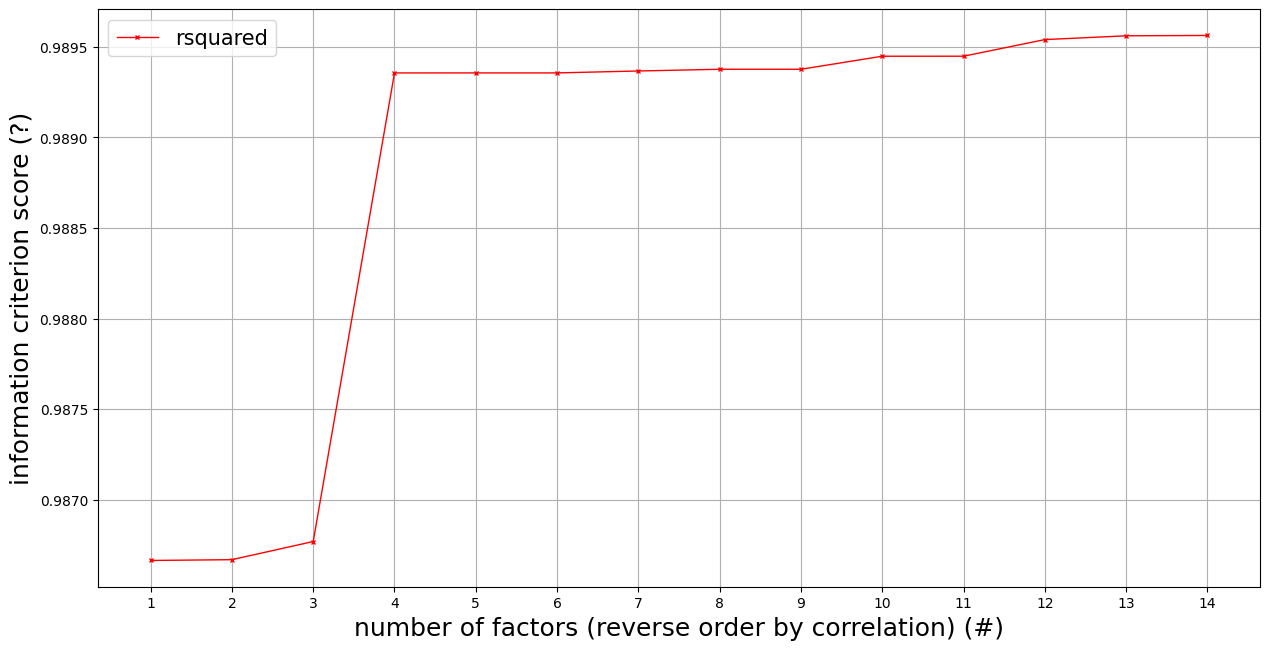

In [9]:
information_score_evolution_for_sampling_random = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_random,
    algorithm_name="random",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_sampling_random)

> `sampling.random ~ dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints`

In [24]:
# Top factors.
print([[f for f in factors_interactions_for_sampling if x==f["xname"]][0] for x in list(df_correlation_sampling_random.index)[:4]])

[{'xname': 'X1POW2', 'fname': 'dataset_size_POW2'}, {'xname': 'X1POW2_X3POW1', 'fname': 'dataset_size_POW2__x__previous_nb_clusters_POW1'}, {'xname': 'X1POW1_X4POW1', 'fname': 'dataset_size_POW1__x__algorithm_nb_to_select_POW1'}, {'xname': 'X1POW1_X2POW1', 'fname': 'dataset_size_POW1__x__previous_nb_constraints_POW1'}]


In [25]:
# Fit the model to the data and print results.
best_model_samp_random = smf.ols(
    formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X4POW1 + X1POW1_X2POW1",  # dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints
    data=df_sampling[df_sampling["algorithm_name"]=="random"],
)
best_results_samp_random = best_model_samp_random.fit()
print(best_results_samp_random.summary())

                            OLS Regression Results                            
Dep. Variable:             time_total   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 7.986e+05
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:46:46   Log-Likelihood:                -39393.
No. Observations:               34375   AIC:                         7.880e+04
Df Residuals:                   34370   BIC:                         7.884e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.6331      0.008    -81.902

> `sampling.random = -0.6331(+/-0.008) + 8.248e-07(+/-9.36e-10)*dataset_size**2 + 7.859e-11(+/-2.07e-11)*dataset_size**2*previous_nb_clusters + -3.451e-07(+/-1.72e-08)*dataset_size*algorithm_nb_to_select + 7.096e-08(+/-7.77e-10)*dataset_size*previous_nb_constraints`

In [26]:
# Define the interpolation function.
def interpolation_samp_random(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> float:
    res: float = 0
    if best_results_samp_random.pvalues["Intercept"] < 0.05:
        res += best_results_samp_random.params["Intercept"]
    if best_results_samp_random.pvalues["X1POW2"] < 0.05:
        res += best_results_samp_random.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_samp_random.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_samp_random.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * previous_nb_clusters
    if best_results_samp_random.pvalues["X1POW1_X4POW1"] < 0.05:
        res += best_results_samp_random.params["X1POW1_X4POW1"] * dataset_size * algorithm_nb_to_select
    if best_results_samp_random.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_samp_random.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    return res

### 2.4.2. Modelize `random_in_same` sampling `algorithm_name`.

In [27]:
# Compute correlation of factors for sampling.
df_correlation_sampling_random_in_same: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="in_same",
)
df_correlation_sampling_random_in_same

,R,R^2,base_factor
X1POW2,0.939045,0.881805,X1
X1POW1_X4POW1,0.611241,0.373616,X1_X4
X1POW2_X3POW1,0.601132,0.361359,X1_X3
X1POW1_X2POW1,0.450943,0.203350,X1_X2
X1POW1_X3POW1_X4POW1,0.341666,0.116735,X1_X3_X4
X1POW1_X2POW1_X3POW1,0.248977,0.061989,X1_X2_X3
X3POW1,0.180146,0.032452,X3
X2POW1_X3POW2,0.147026,0.021617,X2_X3
X3POW2_X4POW1,0.130427,0.017011,X3_X4
X2POW1_X3POW1_X4POW1,0.117858,0.013891,X2_X3_X4


[{'factors': ['X1POW2'], 'scores': {'aic': 63408.50766550592, 'bic': 63425.397835175856, 'rsquared': 0.8818048241104312, 'llf': -31702.25383275296}}, {'factors': ['X1POW2', 'X1POW1_X4POW1'], 'scores': {'aic': 63386.86968620988, 'bic': 63412.204940714786, 'rsquared': 0.8818860731207381, 'llf': -31690.43484310494}}, {'factors': ['X1POW2', 'X1POW1_X4POW1', 'X1POW2_X3POW1'], 'scores': {'aic': 40406.26134320967, 'bic': 40440.04168254955, 'rsquared': 0.9394745056350466, 'llf': -20199.130671604835}}, {'factors': ['X1POW2', 'X1POW1_X4POW1', 'X1POW2_X3POW1', 'X1POW1_X2POW1'], 'scores': {'aic': 36917.27157407493, 'bic': 36959.49699824978, 'rsquared': 0.9453194207787906, 'llf': -18453.635787037467}}, {'factors': ['X1POW2', 'X1POW1_X4POW1', 'X1POW2_X3POW1', 'X1POW1_X2POW1', 'X1POW1_X3POW1_X4POW1'], 'scores': {'aic': 36879.05650781962, 'bic': 36929.727016829434, 'rsquared': 0.9453833537920393, 'llf': -18433.52825390981}}, {'factors': ['X1POW2', 'X1POW1_X4POW1', 'X1POW2_X3POW1', 'X1POW1_X2POW1', 'X1

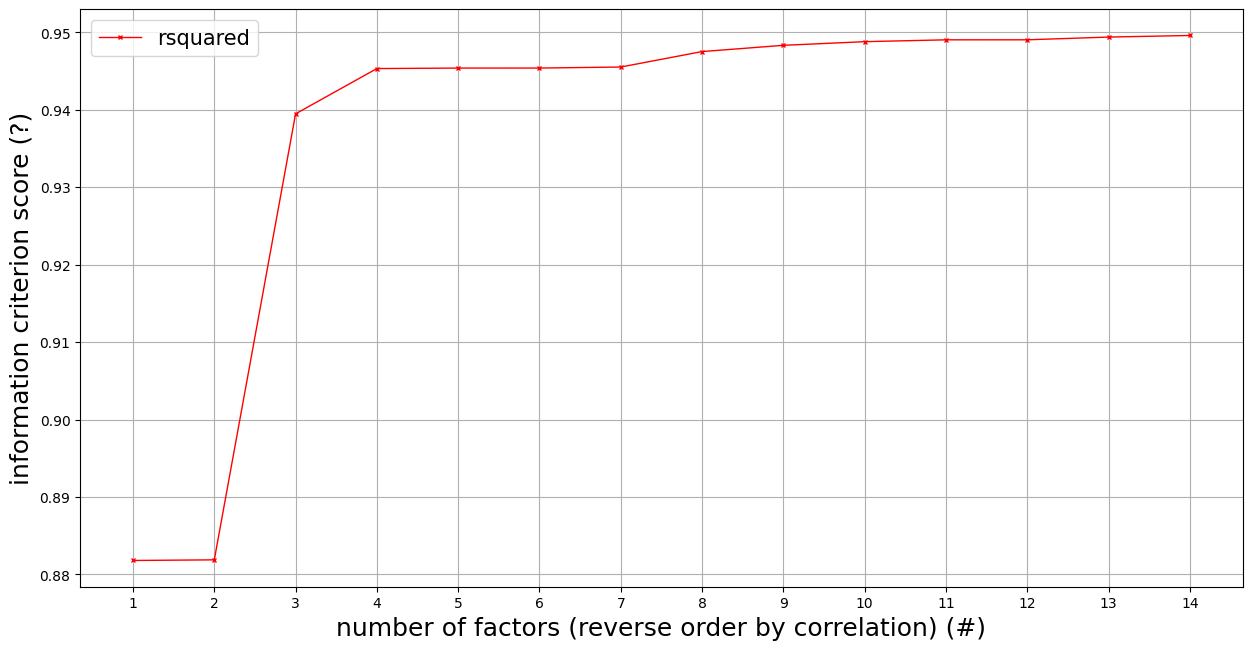

In [28]:
information_score_evolution_for_sampling_random_in_same = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_random_in_same,
    algorithm_name="in_same",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_sampling_random_in_same)

> `sampling.random_in_same ~ dataset_size**2 + dataset_size*algorithm_nb_to_select + dataset_size**2*previous_nb_clusters + dataset_size*previous_nb_constraints`

In [29]:
# Top factors.
print([[f for f in factors_interactions_for_sampling if x==f["xname"]][0] for x in list(df_correlation_sampling_random_in_same.index)[:4]])

[{'xname': 'X1POW2', 'fname': 'dataset_size_POW2'}, {'xname': 'X1POW1_X4POW1', 'fname': 'dataset_size_POW1__x__algorithm_nb_to_select_POW1'}, {'xname': 'X1POW2_X3POW1', 'fname': 'dataset_size_POW2__x__previous_nb_clusters_POW1'}, {'xname': 'X1POW1_X2POW1', 'fname': 'dataset_size_POW1__x__previous_nb_constraints_POW1'}]


In [31]:
# Fit the model to the data and print results.
best_model_samp_random_in_same = smf.ols(
    formula="time_total ~ X1POW2 + X1POW1_X4POW1 + X1POW2_X3POW1 + X1POW1_X2POW1",  # dataset_size**2 + dataset_size*algorithm_nb_to_select + dataset_size**2*previous_nb_clusters + dataset_size*previous_nb_constraints
    data=df_sampling[df_sampling["algorithm_name"]=="in_same"],
)
best_results_samp_random_in_same = best_model_samp_random_in_same.fit()
print(best_results_samp_random_in_same.summary())

                            OLS Regression Results                            
Dep. Variable:             time_total   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.485e+05
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:48:21   Log-Likelihood:                -18454.
No. Observations:               34375   AIC:                         3.692e+04
Df Residuals:                   34370   BIC:                         3.696e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0474      0.004    -11.265

> `sampling.random_in_same = -0.0474(+/-0.004) + 2.682e-07(+/-5.09e-10)*dataset_size**2 + -5.434e-08(+/-9.38e-09)*dataset_size*algorithm_nb_to_select + -2.147e-09(+/-1.13e-11)*dataset_size**2*previous_nb_clusters + -2.56e-08(+/-4.22e-10)*dataset_size*previous_nb_constraints`

In [32]:
# Define the interpolation function.
def interpolation_samp_random_in_same(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> float:
    res: float = 0
    if best_results_samp_random_in_same.pvalues["Intercept"] < 0.05:
        res += best_results_samp_random_in_same.params["Intercept"]
    if best_results_samp_random_in_same.pvalues["X1POW2"] < 0.05:
        res += best_results_samp_random_in_same.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_samp_random_in_same.pvalues["X1POW1_X4POW1"] < 0.05:
        res += best_results_samp_random_in_same.params["X1POW1_X4POW1"] * dataset_size * algorithm_nb_to_select
    if best_results_samp_random_in_same.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_samp_random_in_same.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * previous_nb_clusters
    if best_results_samp_random_in_same.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_samp_random_in_same.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    return res

### 2.4.3. Modelize `farthest_in_same` sampling `algorithm_name`.

In [33]:
# Compute correlation of factors for sampling.
df_correlation_sampling_farthest_in_same: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="farthest",
)
df_correlation_sampling_farthest_in_same

,R,R^2,base_factor
X1POW2,0.981379,0.963105,X1
X1POW2_X3POW1,0.699890,0.489846,X1_X3
X1POW1_X4POW1,0.642015,0.412184,X1_X4
X1POW1_X2POW1,0.493681,0.243721,X1_X2
X1POW1_X3POW1_X4POW1,0.423931,0.179718,X1_X3_X4
X1POW1_X2POW1_X3POW1,0.335356,0.112463,X1_X2_X3
X3POW1,0.099762,0.009952,X3
X2POW1_X3POW1,0.086201,0.007431,X2_X3
X3POW2_X4POW1,0.072463,0.005251,X3_X4
X2POW1_X3POW1_X4POW1,0.070044,0.004906,X2_X3_X4


[{'factors': ['X1POW2'], 'scores': {'aic': 90333.68791158254, 'bic': 90350.57808125248, 'rsquared': 0.9631045320166476, 'llf': -45164.84395579127}}, {'factors': ['X1POW2', 'X1POW2_X3POW1'], 'scores': {'aic': 68068.74930380368, 'bic': 68094.08455830859, 'rsquared': 0.9806957894012878, 'llf': -34031.37465190184}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1'], 'scores': {'aic': 68023.55759975415, 'bic': 68057.33793909402, 'rsquared': 0.9807222729953979, 'llf': -34007.77879987707}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1'], 'scores': {'aic': 62570.10959234317, 'bic': 62612.335016518016, 'rsquared': 0.9835513000080025, 'llf': -31280.054796171586}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1POW1_X3POW1_X4POW1'], 'scores': {'aic': 62539.09112105588, 'bic': 62589.76163006569, 'rsquared': 0.9835670920130274, 'llf': -31263.54556052794}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1POW

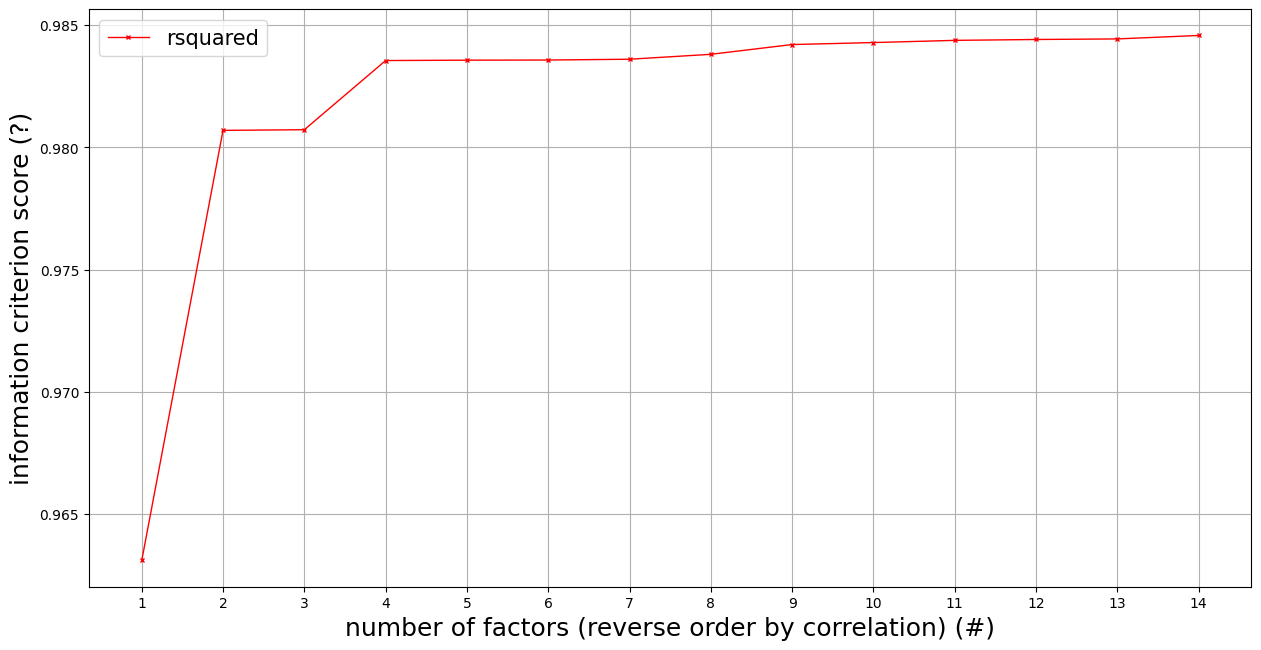

In [34]:
information_score_evolution_for_sampling_farthest_in_same = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_farthest_in_same,
    algorithm_name="farthest",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_sampling_farthest_in_same)

> `sampling.farthest_in_same ~ dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints`

In [35]:
# Top factors.
print([[f for f in factors_interactions_for_sampling if x==f["xname"]][0] for x in list(df_correlation_sampling_farthest_in_same.index)[:4]])

[{'xname': 'X1POW2', 'fname': 'dataset_size_POW2'}, {'xname': 'X1POW2_X3POW1', 'fname': 'dataset_size_POW2__x__previous_nb_clusters_POW1'}, {'xname': 'X1POW1_X4POW1', 'fname': 'dataset_size_POW1__x__algorithm_nb_to_select_POW1'}, {'xname': 'X1POW1_X2POW1', 'fname': 'dataset_size_POW1__x__previous_nb_constraints_POW1'}]


In [46]:
# Fit the model to the data and print results.
best_model_samp_farthest_in_same = smf.ols(
    formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X4POW1 + X1POW1_X2POW1",  # dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints
    data=df_sampling[df_sampling["algorithm_name"]=="farthest"],
)
best_results_samp_farthest_in_same = best_model_samp_farthest_in_same.fit()
print(best_results_samp_farthest_in_same.summary())

                            OLS Regression Results                            
Dep. Variable:             time_total   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 5.138e+05
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:01:31   Log-Likelihood:                -31280.
No. Observations:               34375   AIC:                         6.257e+04
Df Residuals:                   34370   BIC:                         6.261e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0645      0.006    -10.558

> `sampling.farthest_in_same = -0.0645(+/-0.006) + 6.469e-07(+/-7.39e-10)*dataset_size**2 + -3.141e-09(+/-1.64e-11)*dataset_size**2*previous_nb_clusters + -7.796e-08(+/-1.36e-08)*dataset_size*algorithm_nb_to_select + -4.715e-08(+/-6.13e-10)*dataset_size*previous_nb_constraints`

In [47]:
# Define the interpolation function.
def interpolation_samp_farthest_in_same(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> float:
    res: float = 0
    if best_results_samp_farthest_in_same.pvalues["Intercept"] < 0.05:
        res += best_results_samp_farthest_in_same.params["Intercept"]
    if best_results_samp_farthest_in_same.pvalues["X1POW2"] < 0.05:
        res += best_results_samp_farthest_in_same.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_samp_farthest_in_same.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_samp_farthest_in_same.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * previous_nb_clusters
    if best_results_samp_farthest_in_same.pvalues["X1POW1_X4POW1"] < 0.05:
        res += best_results_samp_farthest_in_same.params["X1POW1_X4POW1"] * dataset_size * algorithm_nb_to_select
    if best_results_samp_farthest_in_same.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_samp_farthest_in_same.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    return res

### 2.4.4. Modelize `closest_in_different` sampling `algorithm_name`.

In [48]:
# Compute correlation of factors for sampling.
df_correlation_sampling_closest_in_different: pd.DataFrame = compute_correlation_of_factors(
    df=df_sampling,
    factors_interactions=factors_interactions_for_sampling,
    algorithm_name="closest",
)
df_correlation_sampling_closest_in_different

,R,R^2,base_factor
X1POW2,0.994718,0.989464,X1
X1POW2_X3POW1,0.815050,0.664306,X1_X3
X1POW1_X4POW1,0.649006,0.421209,X1_X4
X1POW1_X2POW1,0.580044,0.336450,X1_X2
X1POW1_X3POW1_X4POW1,0.523555,0.274110,X1_X3_X4
X1POW1_X2POW1_X3POW1,0.487411,0.237570,X1_X2_X3
X1POW1_X2POW1_X4POW1,0.061005,0.003722,X1_X2_X4
X2POW1_X3POW1,0.043898,0.001927,X2_X3
X2POW1,0.035964,0.001293,X2
X2POW1_X3POW1_X4POW1,0.034162,0.001167,X2_X3_X4


[{'factors': ['X1POW2'], 'scores': {'aic': 115961.048268312, 'bic': 115977.93843798194, 'rsquared': 0.9894638816140356, 'llf': -57978.524134156}}, {'factors': ['X1POW2', 'X1POW2_X3POW1'], 'scores': {'aic': 110370.72833416208, 'bic': 110396.06358866699, 'rsquared': 0.9910457925327303, 'llf': -55182.36416708104}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1'], 'scores': {'aic': 110154.84556331446, 'bic': 110188.62590265434, 'rsquared': 0.9911023684618221, 'llf': -55073.42278165723}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1'], 'scores': {'aic': 102793.36610689716, 'bic': 102835.591531072, 'rsquared': 0.9928180221582105, 'llf': -51391.68305344858}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1POW1_X3POW1_X4POW1'], 'scores': {'aic': 102785.16881244029, 'bic': 102835.8393214501, 'rsquared': 0.9928201523656612, 'llf': -51386.58440622014}}, {'factors': ['X1POW2', 'X1POW2_X3POW1', 'X1POW1_X4POW1', 'X1POW1_X2POW1', 'X1PO

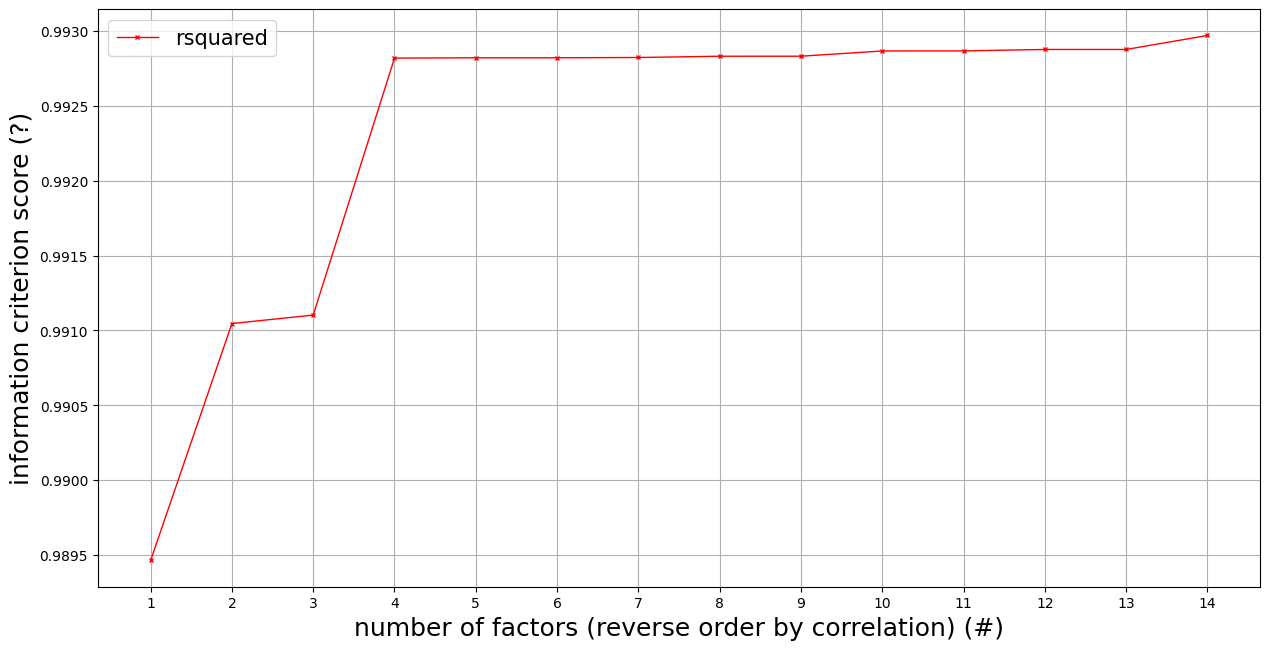

In [49]:
information_score_evolution_for_sampling_closest_in_different = compute_information_score_evolution(
    df=df_sampling,
    df_correlation=df_correlation_sampling_closest_in_different,
    algorithm_name="closest",
    information_criterion_to_plot="rsquared",
)
print(information_score_evolution_for_sampling_closest_in_different)

> `sampling.closest_in_different ~ dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints`

In [50]:
# Top factors.
print([[f for f in factors_interactions_for_sampling if x==f["xname"]][0] for x in list(df_correlation_sampling_closest_in_different.index)[:4]])

[{'xname': 'X1POW2', 'fname': 'dataset_size_POW2'}, {'xname': 'X1POW2_X3POW1', 'fname': 'dataset_size_POW2__x__previous_nb_clusters_POW1'}, {'xname': 'X1POW1_X4POW1', 'fname': 'dataset_size_POW1__x__algorithm_nb_to_select_POW1'}, {'xname': 'X1POW1_X2POW1', 'fname': 'dataset_size_POW1__x__previous_nb_constraints_POW1'}]


In [51]:
# Fit the model to the data and print results.
best_model_samp_closest_in_different = smf.ols(
    formula="time_total ~ X1POW2 + X1POW2_X3POW1 + X1POW1_X4POW1 + X1POW1_X2POW1",  # dataset_size**2 + dataset_size**2*previous_nb_clusters + dataset_size*algorithm_nb_to_select + dataset_size*previous_nb_constraints
    data=df_sampling[df_sampling["algorithm_name"]=="closest"],
)
best_results_samp_closest_in_different = best_model_samp_closest_in_different.fit()
print(best_results_samp_closest_in_different.summary())

                            OLS Regression Results                            
Dep. Variable:             time_total   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.188e+06
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        12:01:38   Log-Likelihood:                -51392.
No. Observations:               34375   AIC:                         1.028e+05
Df Residuals:                   34370   BIC:                         1.028e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.8819      0.011    -80.483

> `sampling.closest_in_different = -0.8819(+/-0.011) + 1.359e-06(+/-1.33e-09)*dataset_size**2 + 2.559e-09(+/-2.94e-11)*dataset_size**2*previous_nb_clusters + -4.517e-07(+/-2.45e-08)*dataset_size*algorithm_nb_to_select + 9.975e-08(+/-1.1e-09)*dataset_size*previous_nb_constraints`

In [52]:
# Define the interpolation function.
def interpolation_samp_closest_in_different(dataset_size, previous_nb_constraints, previous_nb_clusters, algorithm_nb_to_select) -> float:
    res: float = 0
    if best_results_samp_closest_in_different.pvalues["Intercept"] < 0.05:
        res += best_results_samp_closest_in_different.params["Intercept"]
    if best_results_samp_closest_in_different.pvalues["X1POW2"] < 0.05:
        res += best_results_samp_closest_in_different.params["X1POW2"] * np.power(dataset_size,2)
    if best_results_samp_closest_in_different.pvalues["X1POW2_X3POW1"] < 0.05:
        res += best_results_samp_closest_in_different.params["X1POW2_X3POW1"] * np.power(dataset_size,2) * previous_nb_clusters
    if best_results_samp_closest_in_different.pvalues["X1POW1_X4POW1"] < 0.05:
        res += best_results_samp_closest_in_different.params["X1POW1_X4POW1"] * dataset_size * algorithm_nb_to_select
    if best_results_samp_closest_in_different.pvalues["X1POW1_X2POW1"] < 0.05:
        res += best_results_samp_closest_in_different.params["X1POW1_X2POW1"] * dataset_size * previous_nb_constraints
    return res

### 2.4.5. Print all sampling computation time model.

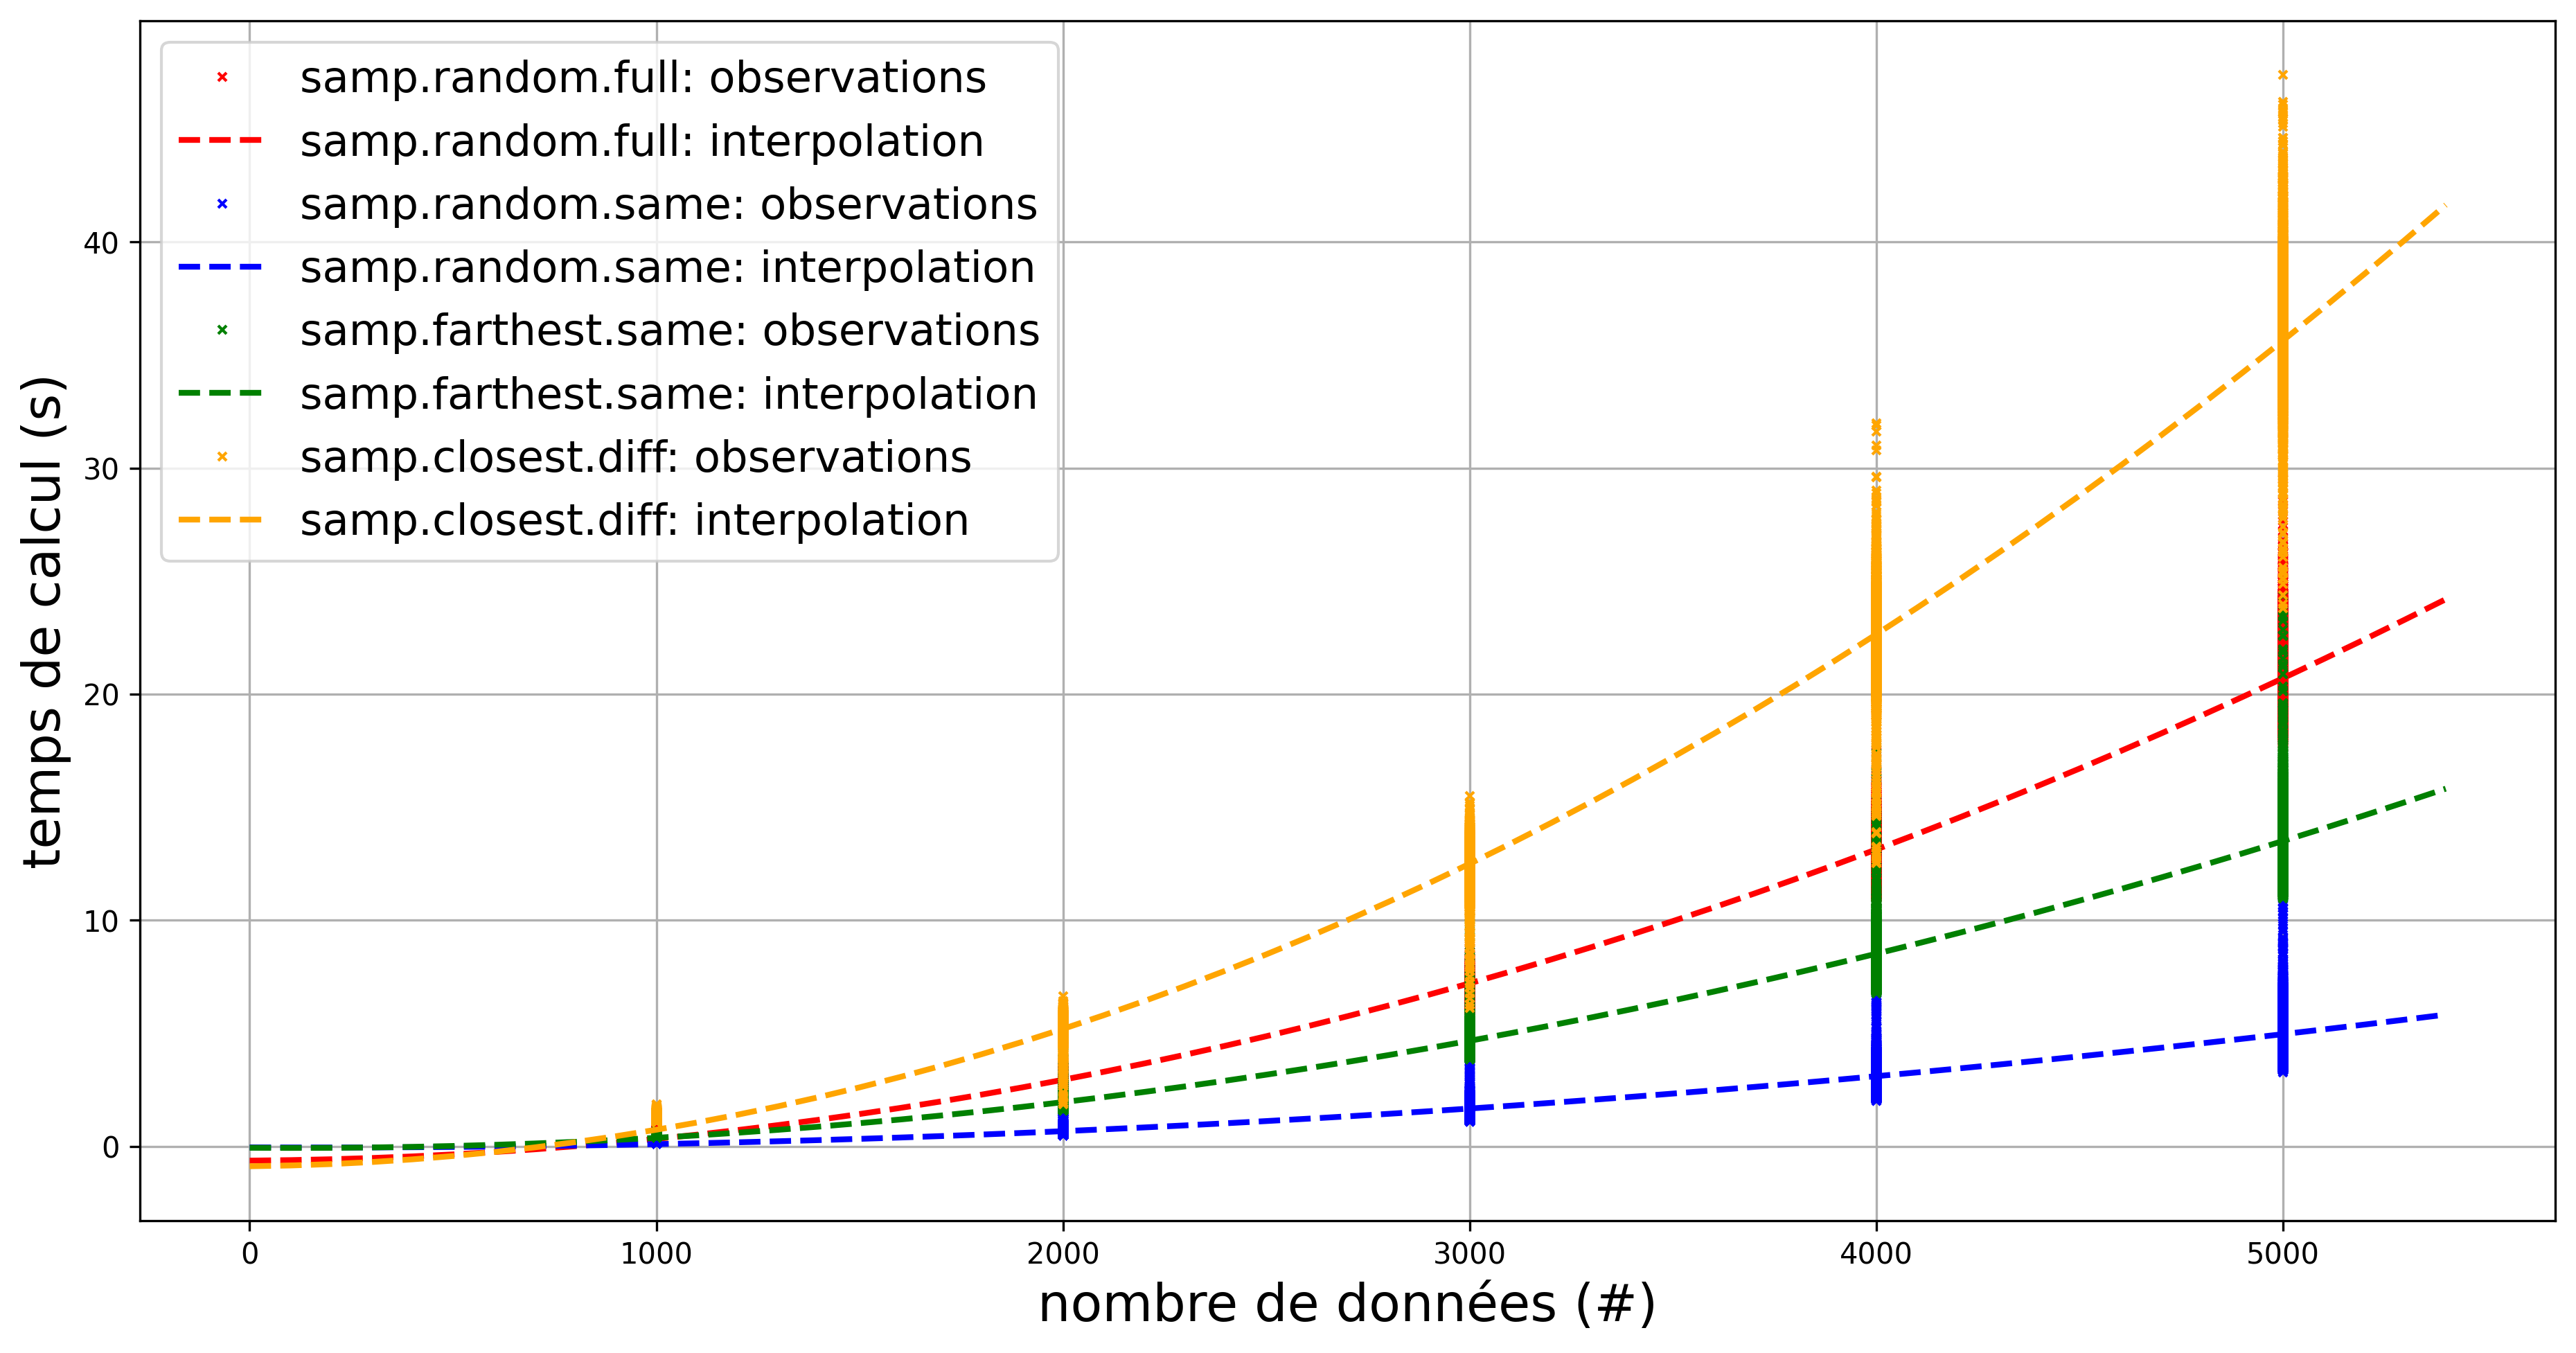

In [53]:
# Create a new figure.
fig_plot_sampling: Figure = plt.figure(figsize=(15, 7.5), dpi=300)
axis_plot_sampling = fig_plot_sampling.gca()

# Plot computation time for random.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="random"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="random"]["time_total"],  # y
    label="samp.random.full: observations",
    marker="x",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x1
    [
        np.mean([
            interpolation_samp_random(x1, x2, x3, x4)
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="samp.random.full: interpolation",
    marker="",
    markerfacecolor="red",
    markersize=3,
    color="red",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for random_in_same.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="in_same"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="in_same"]["time_total"],  # y
    label="samp.random.same: observations",
    marker="x",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_random_in_same(x1, x2, x3, x4)
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="samp.random.same: interpolation",
    marker="",
    markerfacecolor="blue",
    markersize=3,
    color="blue",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for farthest_in_same.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="farthest"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="farthest"]["time_total"],  # y
    label="samp.farthest.same: observations",
    marker="x",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_farthest_in_same(x1, x2, x3, x4)
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="samp.farthest.same: interpolation",
    marker="",
    markerfacecolor="green",
    markersize=3,
    color="green",
    linewidth=2,
    linestyle="--",
)

# Plot computation time for closest_in_different.
axis_plot_sampling.plot(
    df_sampling[df_sampling["algorithm_name"]=="closest"]["dataset_size"],  # x
    df_sampling[df_sampling["algorithm_name"]=="closest"]["time_total"],  # y
    label="samp.closest.diff: observations",
    marker="x",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=0,
    linestyle="",
)
axis_plot_sampling.plot(
    range(0, 5500, 100),  # x
    [
        np.mean([
            interpolation_samp_closest_in_different(x1, x2, x3, x4)
            for x2 in range(0, 5500, 500)
            for x3 in range(0, 55, 5)
            for x4 in range(0, 300, 50)
        ])
        for x1 in range(0, 5500, 100)
    ],
    label="samp.closest.diff: interpolation",
    marker="",
    markerfacecolor="orange",
    markersize=3,
    color="orange",
    linewidth=2,
    linestyle="--",
)

# Set axis name.
axis_plot_sampling.set_xlabel("nombre de données (#)", fontsize=18,)
axis_plot_sampling.set_ylabel("temps de calcul (s)", fontsize=18,)
#axis_plot_sampling.set_ylim(ymax=30000)

# Plot the legend.
axis_plot_sampling.legend(fontsize=15,)

# Plot the grid.
axis_plot_sampling.grid(True)